
# 4 species Competitive Lotka-Volterra

Adapted from the numpyro predator-prey example
http://num.pyro.ai/en/stable/examples/ode.html


In [1]:
import argparse
import os

import matplotlib
import matplotlib.pyplot as plt

from jax.experimental.ode import odeint
import jax.numpy as jnp
from jax.random import PRNGKey
from jax import nn

import numpyro
import numpyro.distributions as dist
from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd
import numpy as np

import arviz as az

NUM_CORES = 1
numpyro.set_host_device_count(NUM_CORES)

/home/DIDE/tmellan/anaconda3/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/home/DIDE/tmellan/anaconda3/lib/python3.7/site-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


In [2]:
numpyro.set_platform('gpu')

In [3]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [4]:
df=pd.read_csv("../data/sim3.csv", header = None)
week = np.array(df.iloc[:,0])
data = np.array([df.iloc[:,1],df.iloc[:,2],df.iloc[:,3]]).T
trans_data =  np.round(100 * data)
trans_data[:,2] = 100 - (trans_data[:,0] + trans_data[:,1])
col12 = trans_data[...,0:2]
col4 = np.random.randint(0, 4, trans_data.shape[0])
col3 = trans_data[...,2] - col4
trans_data = np.append(col12, np.append([col3], [col4],0).T, 1)

trans_data[:5]

array([[75.,  7., 18.,  0.],
       [67., 13., 20.,  0.],
       [59.,  8., 30.,  3.],
       [50., 12., 36.,  2.],
       [44., 12., 44.,  0.]])

In [6]:
def dz_dt(z, 
          t, 
          inherent_growth_rate, 
          self_interaction,
          comp_interaction
         ):

    z1 = z[0]
    z2 = z[1]
    z3 = z[2]
    z4 = z[3]
    
    r1, r2, r3, r4 = (inherent_growth_rate[..., 0], 
                      inherent_growth_rate[..., 1], 
                      inherent_growth_rate[..., 2], 
                      inherent_growth_rate[..., 3], 
                     )
    
    a11, a22, a33, a44 = (self_interaction[..., 0], 
                          self_interaction[..., 1], 
                          self_interaction[..., 2], 
                          self_interaction[..., 3], 
                         )
    
    a12, a13, a14, a21, a23, a24, a31, a32, a34 = (comp_interaction[..., 0], 
                                                   comp_interaction[..., 1],
                                                   comp_interaction[..., 2], 
                                                   comp_interaction[..., 3], 
                                                   comp_interaction[..., 4], 
                                                   comp_interaction[..., 5], 
                                                   comp_interaction[..., 6], 
                                                   comp_interaction[..., 7], 
                                                   comp_interaction[..., 8], 
                         )

    
    dz1_dt = r1 * z1 * (1 - (a11 * z1 + a12 * z2 + a13 * z3 + a14 * z4))
    dz2_dt = r2 * z2 * (1 - (a21 * z1 + a22 * z2 + a23 * z3 + a24 * z4))
    dz3_dt = r3 * z3 * (1 - (a31 * z1 + a32 * z2 + a33 * z3 + a34 * z4))
    dz4_dt = - dz1_dt - dz2_dt - dz3_dt
    
    return jnp.stack([dz1_dt, dz2_dt, dz3_dt, dz4_dt])


def model(N : int, y = None):

    ts = jnp.arange(float(N))
    
    z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1.).expand([4]))
    
    scale_inherent_growth_rate = numpyro.sample("scale_inherent_growth_rate", dist.Normal(0.01,0.01))
    loc_inherent_growth_rate = numpyro.sample("loc_inherent_growth_rate", dist.Normal(0.01,0.01))
    with numpyro.plate("plate_2", 4):
        inherent_growth_rate = numpyro.sample("inherent_growth_rate", 
                                   dist.TruncatedNormal(
                                       low = 0.0,
                                       loc = loc_inherent_growth_rate,
                                       scale = scale_inherent_growth_rate,
                                       )
                                  )
        
    scale_self_interaction = numpyro.sample("scale_self_interaction", dist.Normal(0.01,0.01))
    loc_self_interaction = numpyro.sample("loc_self_interaction", dist.Normal(0.01,0.01))
    with numpyro.plate("plate_3", 4):
        self_interaction = numpyro.sample("self_interaction", 
                                   dist.TruncatedNormal(
                                       low = 0.0,
                                       loc = loc_self_interaction,
                                       scale = scale_self_interaction,
                                       )
                                  )
        
    scale_comp_interaction = numpyro.sample("scale_comp_interaction", dist.Normal(0.01,0.01))
    loc_comp_interaction = numpyro.sample("loc_comp_interaction", dist.Normal(0.01,0.01))
    with numpyro.plate("plate_4", 9):
        comp_interaction = numpyro.sample("comp_interaction", 
                                   dist.TruncatedNormal(
                                       low = 0.0,
                                       loc = loc_comp_interaction,
                                       scale = scale_comp_interaction,
                                       )
                                  )

    
    z = odeint(dz_dt, z_init, ts, inherent_growth_rate, self_interaction,
          comp_interaction, rtol = 1e-7, atol = 1e-6, mxstep = 1000)
    numpyro.sample("y", dist.Multinomial(logits = z, total_count = 100), obs = y)
    
    
mcmc = MCMC(
    NUTS(model, dense_mass = True),
    num_samples = 500,
    num_warmup = 500,
    num_chains = NUM_CORES,
    progress_bar = True,
)

mcmc.run(PRNGKey(1), N = trans_data.shape[0], y = trans_data)
mcmc.print_summary()

  0%|          | 0/1000 [00:00<?, ?it/s]


RuntimeError: jaxlib/cusolver_kernels.cc:44: operation cusolverDnCreate(&handle) failed: cuSolver internal error

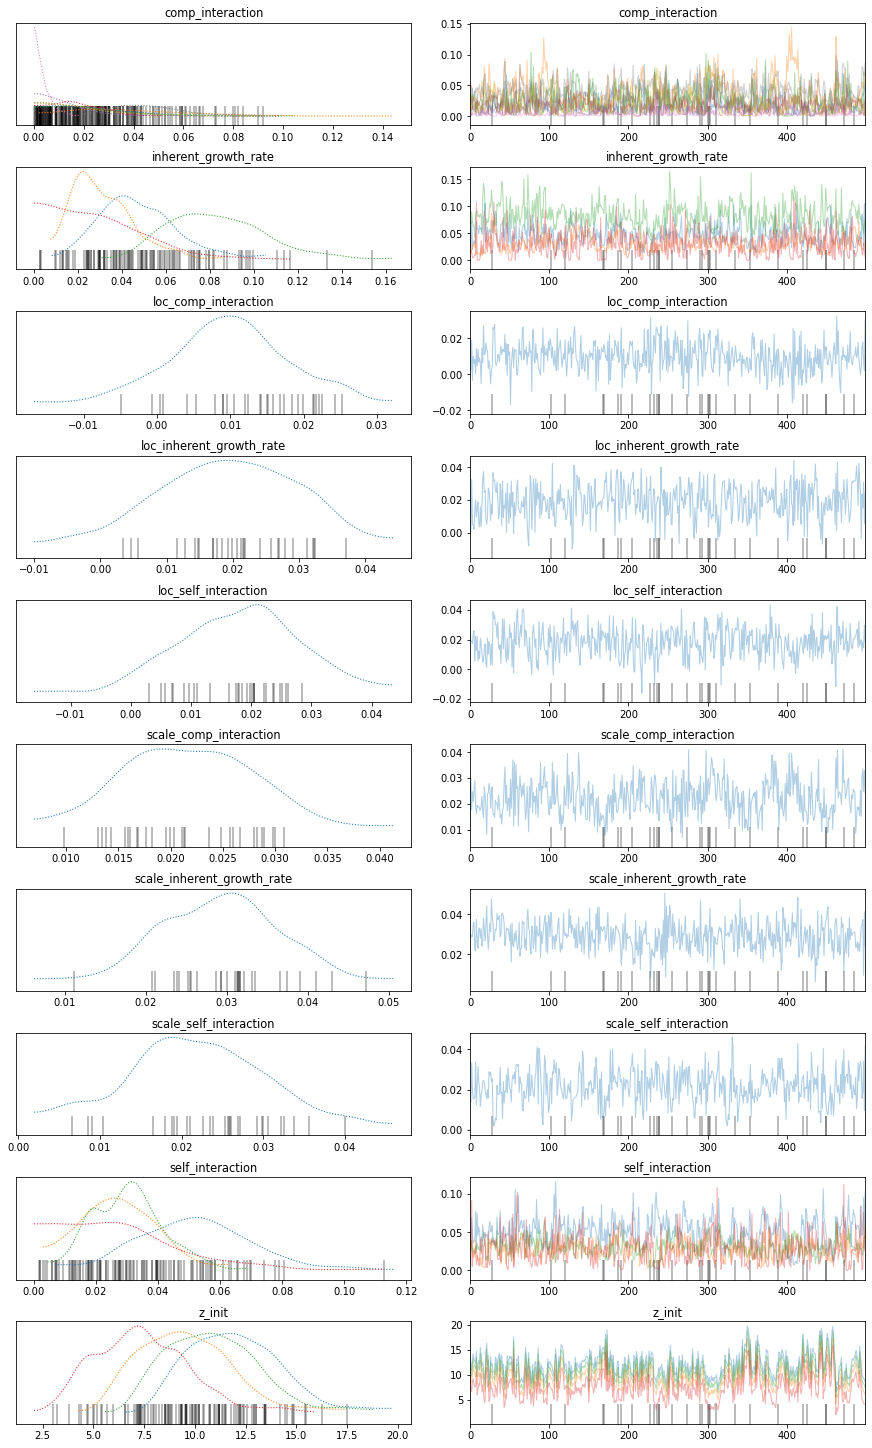

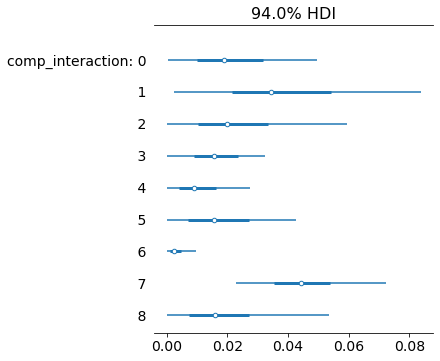

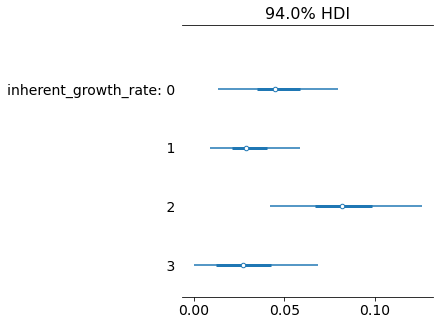

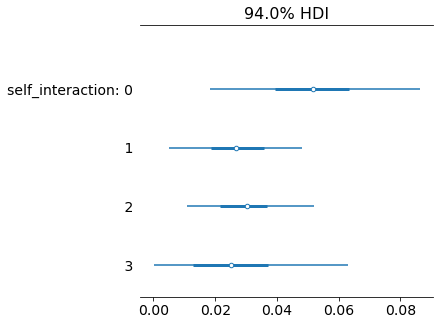

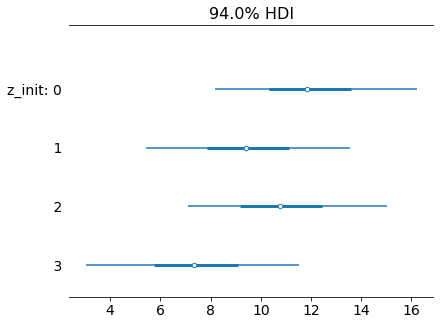

/Users/thomasmellan/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/pairplot.py:238: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


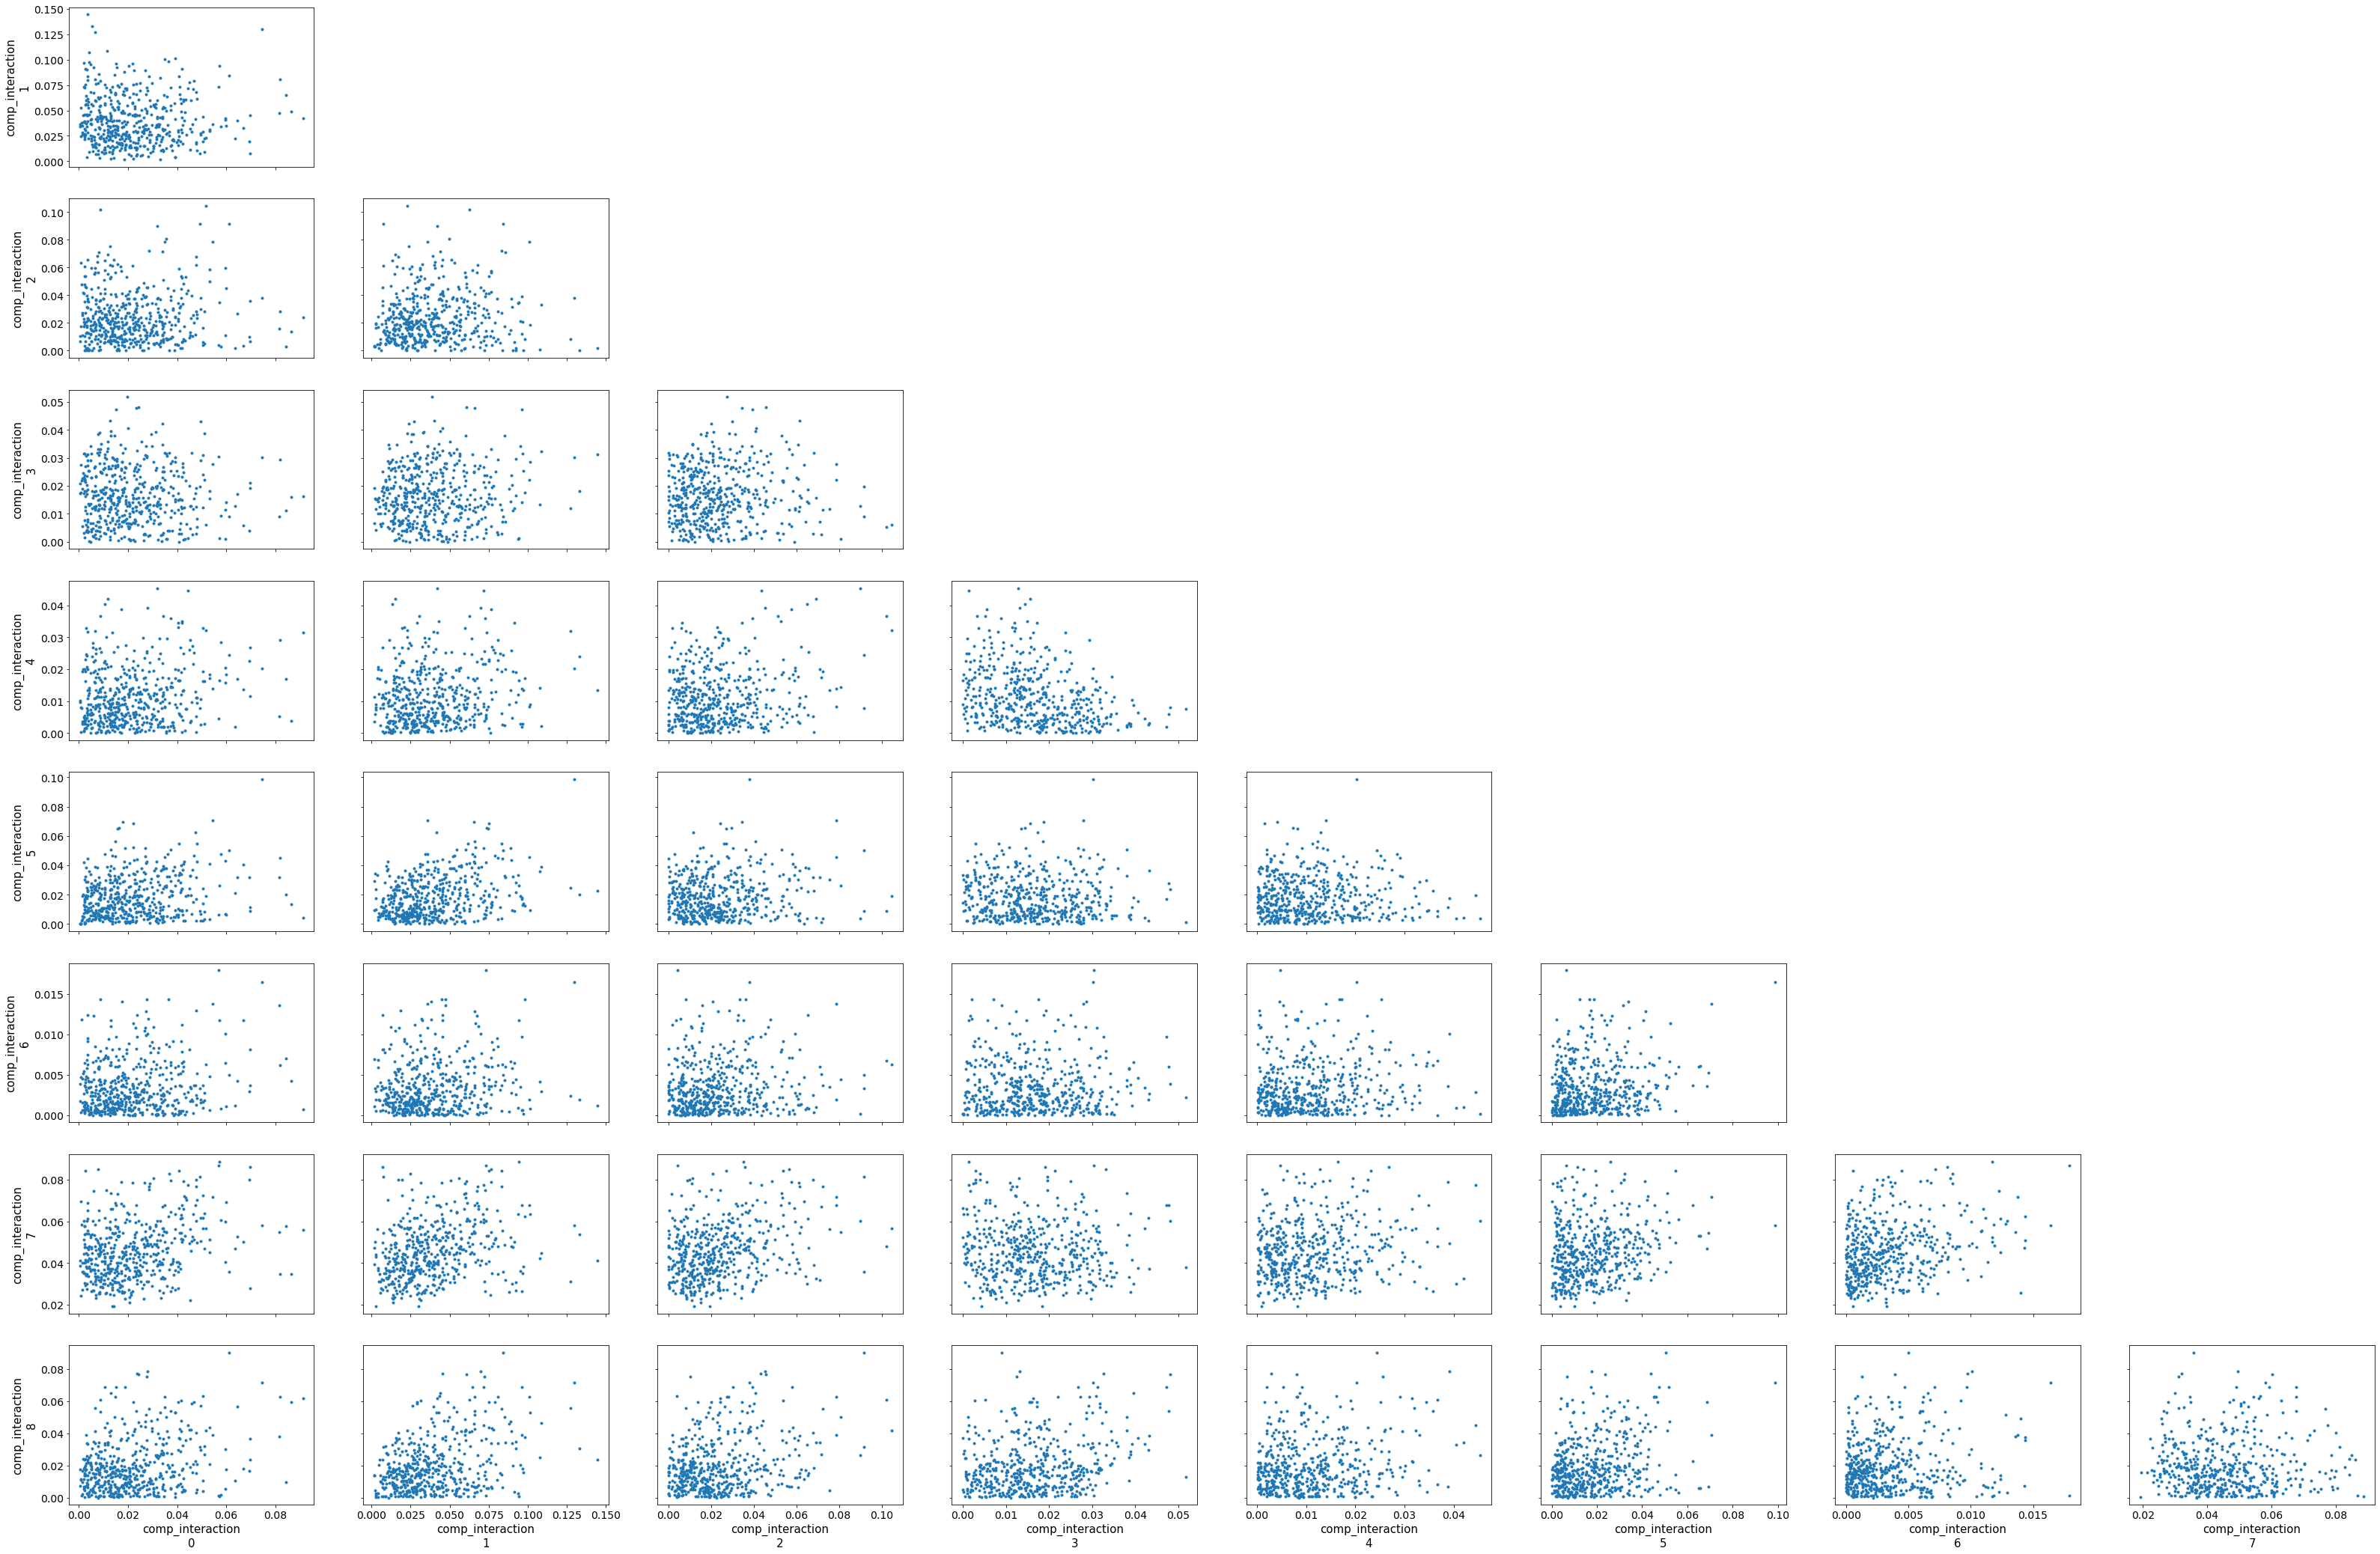

In [40]:
az.plot_trace(az.from_numpyro(mcmc), compact = True, combined = True);
plt.show()

az.plot_forest(az.from_numpyro(mcmc), var_names = ['comp_interaction'], combined = True)
plt.show()

az.plot_forest(az.from_numpyro(mcmc), var_names = ['inherent_growth_rate'], combined = True)
plt.show()

az.plot_forest(az.from_numpyro(mcmc), var_names = ['self_interaction'], combined = True)
plt.show()

az.plot_forest(az.from_numpyro(mcmc), var_names = ['z_init'], combined = True)
plt.show()

az.plot_pair(az.from_numpyro(mcmc))
plt.show()

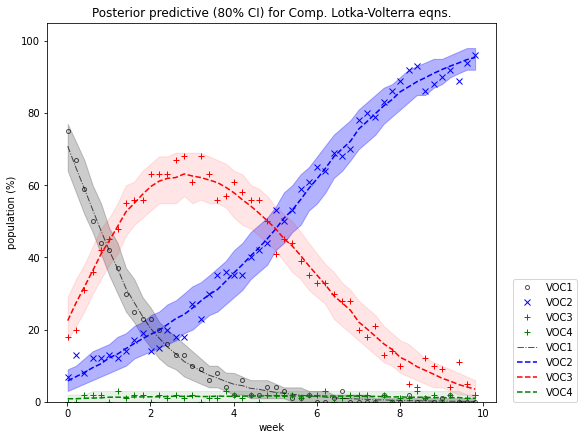

In [41]:
pop_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), trans_data.shape[0])["y"]
mu, pi = jnp.mean(pop_pred, 0), np.percentile(pop_pred, (10, 90), 0)

plt.figure(figsize=(8, 6), constrained_layout=True)
plt.plot(week, trans_data[:, 0], "ko", mfc="none", ms=4, label="VOC1", alpha=0.67)
plt.plot(week, trans_data[:, 1], "bx", label="VOC2")
plt.plot(week, trans_data[:, 2], "r+", label="VOC3")
plt.plot(week, trans_data[:, 3], "g+", label="VOC4")
plt.plot(week, mu[:, 0], "k-.", label="VOC1", lw=1, alpha=0.67)
plt.plot(week, mu[:, 1], "b--", label="VOC2")
plt.plot(week, mu[:, 2], "r--", label="VOC3")
plt.plot(week, mu[:, 3], "g--", label="VOC4")
plt.fill_between(week, pi[0, :, 0], pi[1, :, 0], color="k", alpha=0.2)
plt.fill_between(week, pi[0, :, 1], pi[1, :, 1], color="b", alpha=0.3)
plt.fill_between(week, pi[0, :, 2], pi[1, :, 2], color="r", alpha=0.1)
plt.fill_between(week, pi[0, :, 3], pi[1, :, 3], color="g", alpha=0.1)
plt.gca().set(ylim=(0, 105), xlabel="week", ylabel="population (%)")
plt.title("Posterior predictive (80% CI) for Comp. Lotka-Volterra eqns.")
plt.legend(loc=(1.04,0))
plt.show()